# Sparkify Churn Prediction

## 1. Load and Clean Dataset
Loading and cleaning the dataset, checking for invalid or missing data - for example, records without user IDs or session IDs.

### 1.1. Importing libraries and setting up notebook

In [1]:
# Import libraries

from itertools import chain

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, from_unixtime, year, weekofyear, substring, encode, decode, split, desc, avg, first, concat_ws, countDistinct, sum as Fsum, max as Fmax, min as Fmin
from pyspark.sql.types import StringType, LongType, IntegerType, DateType, TimestampType
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.pipeline import PipelineModel

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import ticker

from build_axes import Hist, Barh, BarhStacked2  # Abstraction of the matplotlib library to make better data visualizations with fewer lines of code
plt.style.use('ggplot')  # Remove this line after all the visualizations are custom made

from user_agents import parse

In [2]:
# Configure pandas output display settings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
# Correct jupyter lab autocomplete not working

%config Completer.use_jedi = False

### 1.2. Loading data

In [4]:
# Create spark session

spark = (SparkSession
    .builder
    .appName('Sparkify')
    .getOrCreate())

In [5]:
# Show link to spark UI at localhost:4040

spark

In [12]:
# Read sparkify dataset

filepath = 'mini_sparkify_event_data.json'
df_log = spark.read.json(filepath)

# Full dataset (12 Gb, 20 million rows)
# event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'

# Mini dataset (128 Mb, 200 thousand rows, 1% of the full dataset)
# event_data = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

In [7]:
print('df_log shape:', (df_log.count(), len(df_log.columns)))

df_log shape: (286500, 18)


In [8]:
df_log.limit(5).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


### 1.3. Adjusting data types

In [9]:
df_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Adjust the data types

df_log = df_log \
    .withColumn('registration', from_unixtime(col('registration')/1000).cast(TimestampType())) \
    .withColumn('status', col('status').cast(StringType())) \
    .withColumn('ts', from_unixtime(col('ts')/1000).cast(TimestampType())) \
    .withColumn('userId', col('userId').cast(LongType()))

### 1.4. Removing missing data

In [11]:
df_log_valid = df_log.dropna(how='any', subset=['userId', 'sessionId'])

old_rows, old_columns = df_log.count(), df_log.columns
new_rows, new_columns = df_log_valid.count(), df_log_valid.columns

print('df_log shape:\t\t', (old_rows, len(old_columns)))
print('df_log_valid shape:\t', (new_rows, len(new_columns)))
print('{} rows with empty user and session IDs removed'.format(old_rows - new_rows))

df_log shape:		 (286500, 18)
df_log_valid shape:	 (278154, 18)
8346 rows with empty user and session IDs removed


### 1.5. Correcting encoding

In [12]:
# Show example of string with wrong encoding

record = '''userId == 30
            and sessionId == 29
            and itemInSession == 68'''

encoding_example = df_log_valid.where(record).collect()[0][0]

print('String should be:\t Björk')
print('String currently is:\t {}'.format(encoding_example))

String should be:	 Björk
String currently is:	 BjÃÂ¶rk


In [13]:
def encode_decode_column(df, column, encoding, decoding):
    """Encode a column from a dataframe and then decode it.
    
    Parameters:
        df (pyspark.sql.dataframe.DataFrame): The dataframe that contains the column.
        column (str): The name of the column to be encoded and decoded.
        encoding (str): The charset of the encoding (one of 'US-ASCII', 'ISO-8859-1', 'UTF-8', 'UTF-16BE', 'UTF-16LE', 'UTF-16').
        decoding (str): The charset of the decoding (one of 'US-ASCII', 'ISO-8859-1', 'UTF-8', 'UTF-16BE', 'UTF-16LE', 'UTF-16').
    
    Returns:
        df (pyspark.sql.dataframe.DataFrame): The dataframe with the column properly encoded and decoded
        
    Example:
        df = encode_decode_column(df, 'column_name', 'ISO-8859-1', 'UTF-8')
    """
    
    df = df.withColumn(column, encode(column, encoding))
    df = df.withColumn(column, decode(column, decoding))
    
    return df

In [14]:
categorical_columns = list(filter(lambda c: c[1] == 'string', df_log_valid.dtypes))
categorical_columns = [item[0] for item in categorical_columns]

In [15]:
# Fix the wrong encoding for the columns that are strings,
# and in order to retrieve the correct characters the encode-decode process must be done twice.

for column in categorical_columns:
    df_log_valid = encode_decode_column(df_log_valid, column, 'ISO-8859-1', 'UTF-8')
    df_log_valid = encode_decode_column(df_log_valid, column, 'ISO-8859-1', 'UTF-8')

In [16]:
# Test if the previous example is correct now

encoding_example_fixed = df_log_valid.where(record).collect()[0][0]

print('String should be:\t Björk')
print('String currently is:\t {}'.format(encoding_example_fixed))

String should be:	 Björk
String currently is:	 Björk


### 1.6. Parsing user agent

In [17]:
# Show some userAgent values

df_log_valid.select('userAgent').dropDuplicates(['userAgent']).limit(5).toPandas().head()

,userAgent
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"""
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"""
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"""


In [18]:
# Create the parsing functions with the user_agents library

get_browser     = udf(lambda x: parse(x).browser.family, StringType())
get_os          = udf(lambda x: parse(x).os.family, StringType())
get_device      = udf(lambda x: parse(x).device.family, StringType())
get_is_phone    = udf(lambda x: 1 if parse(x).is_mobile else 0, IntegerType())
get_is_tablet   = udf(lambda x: 1 if parse(x).is_tablet else 0, IntegerType())
get_is_computer = udf(lambda x: 1 if parse(x).is_pc else 0, IntegerType())

In [19]:
df_log_valid = df_log_valid \
    .withColumn('browser', get_browser('userAgent')) \
    .withColumn('os', get_os('userAgent')) \
    .withColumn('device', get_device('userAgent')) \
    .withColumn('isPhone', get_is_phone('userAgent')) \
    .withColumn('isTablet', get_is_tablet('userAgent')) \
    .withColumn('isComputer', get_is_computer('userAgent'))

In [20]:
# Show comparison between original values and parsing result

df_log_valid \
    .select('userAgent', 'browser', 'os', 'device', 'isPhone', 'isTablet', 'isComputer') \
    .dropDuplicates(['userAgent']) \
    .limit(5) \
    .toPandas() \
    .head()

,userAgent,browser,os,device,isPhone,isTablet,isComputer
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",Chrome,Mac OS X,Mac,0,0,1
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",Chrome,Windows,Other,0,0,1
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0,Firefox,Ubuntu,Other,0,0,1
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",Chrome,Mac OS X,Mac,0,0,1
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36""",Chrome,Mac OS X,Mac,0,0,1


## 2. Exploratory Data Analysis

### 2.1. Main stats

In [21]:
distinct_user_ids = df_log_valid.dropDuplicates(['userId']).count()
print('Distinct user IDs:', distinct_user_ids)

Distinct user IDs: 225


In [22]:
# ADD BACK THE FUNCTION TO SHOW THE PERIOD OF THE DATE FIELDS

# Earliest registration: 2018-03-18 10:44:35
# Latest registration: 2018-11-26 13:49:14
# Earliest ts: 2018-09-30 21:01:57
# Latest ts: 2018-12-02 23:11:16

### 2.2. Visualizing entire log

#### 2.2.1. Numerical features

Note:
Despite the columns `userId`, `sessionId` and `itemInSession` being numerical, they are not quantitative. Which means that we can not extract value from mathematical operations with them. Nonetheless, they will still be visualized in this section.

In [23]:
n1 = df_log_valid.select('userId').toPandas()
n2 = df_log_valid.select('sessionId').toPandas()
n3 = df_log_valid.select('itemInSession').toPandas()
n4 = df_log_valid.select('length').toPandas()

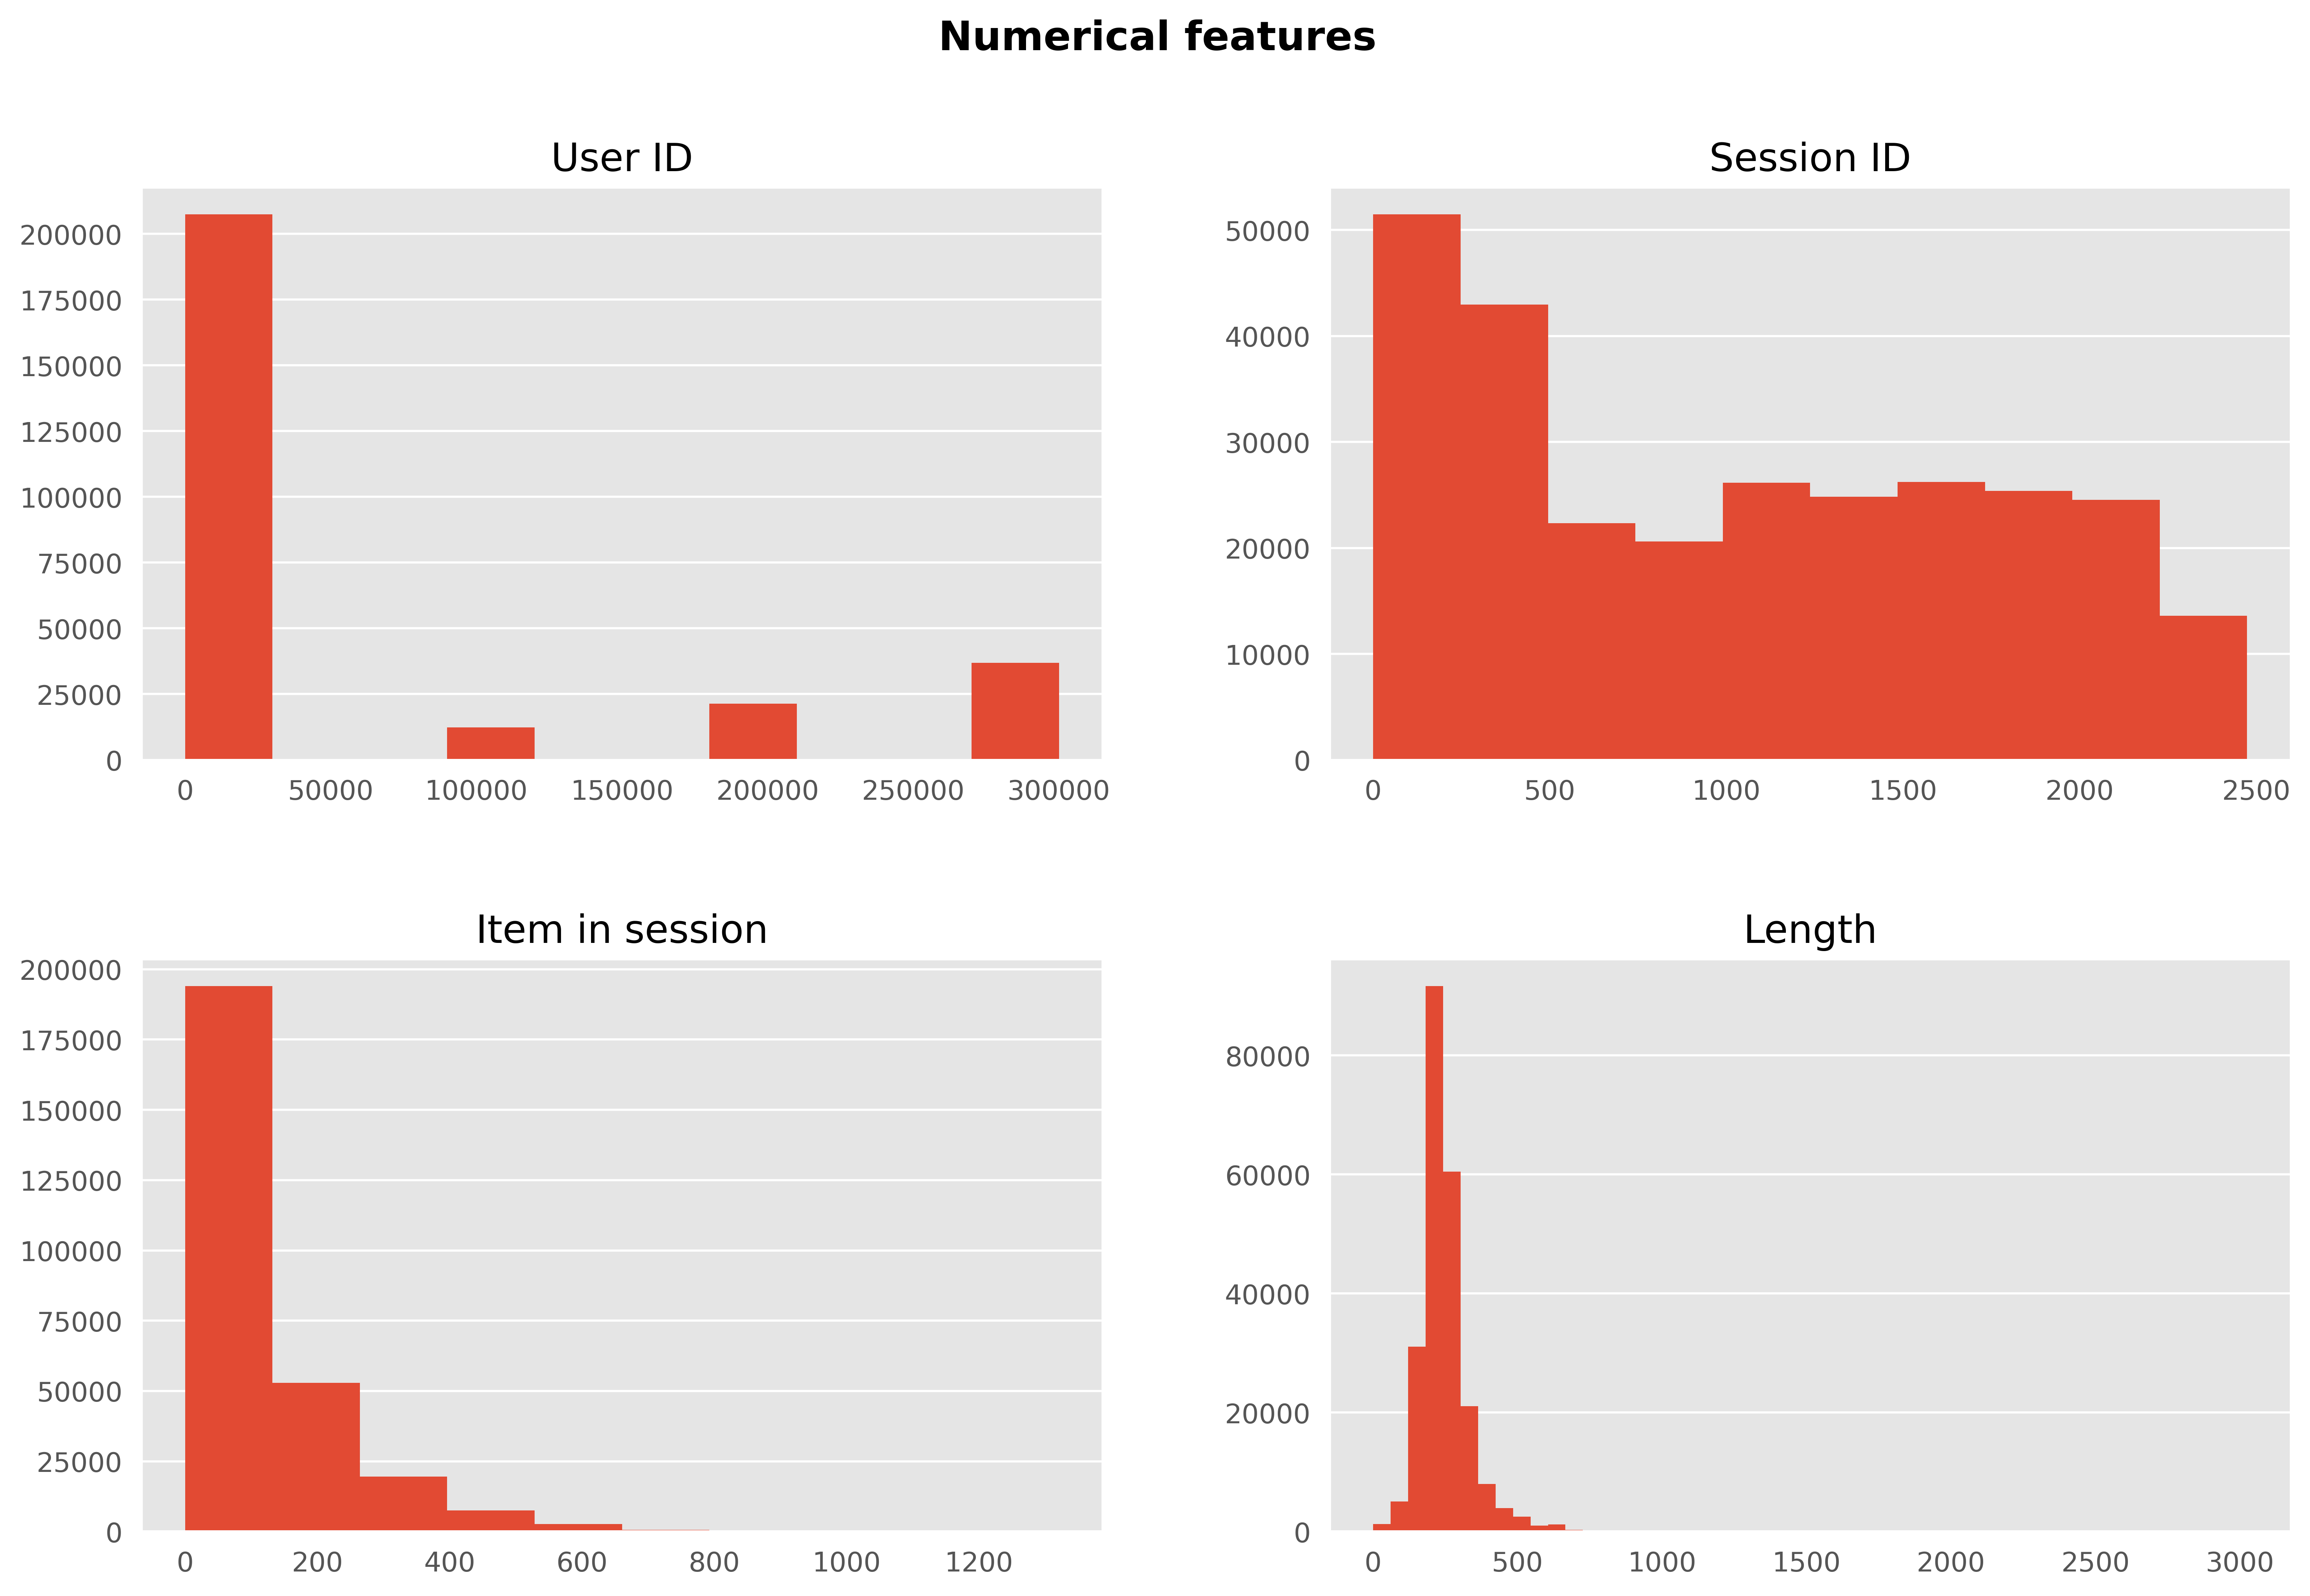

In [24]:
fig = plt.figure(figsize=(12, 8), dpi=500)
grid = gs.GridSpec(nrows=2, ncols=2)

fig.text(0.5, 1, 'Numerical features', ha='center', size=15, weight='bold')

Hist(n1, title='User ID').subplot(grid, 0, 0)
Hist(n2, title='Session ID').subplot(grid, 0, 1)
Hist(n3, title='Item in session').subplot(grid, 1, 0)
Hist(n4, title='Length', bins=50).subplot(grid, 1, 1)
    
plt.tight_layout(h_pad=4, w_pad=4, rect=(0, 0, 1, 0.96))
plt.show();

#### 2.2.2. Categorical features

In [25]:
def group_by_count_column(df, column, n_labels=10, n_label_chars=20):
    """Perform a group by and count the values from a desired column in a dataframe.
    
    Parameters:
        df (pyspark.sql.dataframe.DataFrame): The dataframe that contains the column.
        column (str): The name of the column to perform the group by and count its values.
    
    Returns:
        x (list of str): A list with the distinct labels from the column, sorted by the count.
        y (list of int): A list with the count of each label, sorted by the count.
    """
    
    group_by_count = df.select(column).groupby(column).count().toPandas().sort_values(by='count')
    
    x = group_by_count[column][-n_labels:]
    x = x.apply(lambda s: 'None' if s is None else s)
    x = x.apply(lambda s: s[:n_label_chars] + '...' if len(s) >= n_label_chars else s)
    
    y = group_by_count['count'][-n_labels:]
    
    return x, y

In [26]:
x_series, y_series = [], []
categorical_columns.remove('userAgent')  # User agent will be parsed and plotted latter

for column in categorical_columns:
    x, y = group_by_count_column(df_log_valid, column)
    x_series.append(x)
    y_series.append(y)

In [27]:
c1x, c2x, c3x, c4x, c5x, c6x, c7x, c8x, c9x, c10x, c11x = x_series
c1y, c2y, c3y, c4y, c5y, c6y, c7y, c8y, c9y, c10y, c11y = y_series

In [28]:
fig = plt.figure(figsize=(12, 20), dpi=500)
grid = gs.GridSpec(nrows=6, ncols=2)

fig.text(0.5, 1, 'Categorical features (top 20 classes)', ha='center', size=15, weight='bold')

Barh(c1x, c1y, title='Artist').subplot(grid, 0, 0)
Barh(c2x, c2y, title='Auth').subplot(grid, 0, 1)
Barh(c3x, c3y, title='First name').subplot(grid, 1, 0)
Barh(c4x, c4y, title='Gender', nbins=6).subplot(grid, 1, 1)
Barh(c5x, c5y, title='Last name').subplot(grid, 2, 0)
Barh(c6x, c6y, title='Level').subplot(grid, 2, 1)
Barh(c7x, c7y, title='Location').subplot(grid, 3, 0)
Barh(c8x, c8y, title='Method').subplot(grid, 3, 1)
Barh(c9x, c9y, title='Page').subplot(grid, 4, 0)
Barh(c10x, c10y, title='Song').subplot(grid, 4, 1)
Barh(c11x, c11y, title='Status').subplot(grid, 5, 0)
    
plt.tight_layout(h_pad=3, w_pad=2, rect=(0, 0, 1, 0.985))
plt.show();

### 2.3. Defining churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [29]:
# Flag the churn

flag_cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_log_valid = df_log_valid.withColumn('churn', flag_cancellation_event('page'))

In [30]:
window_val = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, Window.currentRow)
df_log_valid = df_log_valid.withColumn('churned', Fsum('churn').over(window_val))

In [31]:
df_log_valid \
    .select('userId', 'churned') \
    .dropDuplicates(['userId']) \
    .groupBy('churned') \
    .count() \
    .show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



In [32]:
# Add the cohort

df_log_valid = df_log_valid.withColumn('cohort', substring('registration', 1, 7))

## 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### 3.1. Building users features matrix

In [33]:
df_users_features = df_log_valid.select('userId', 'churned').dropDuplicates(['userId'])

In [34]:
# Create year and week columns to aggregate data in the next steps

df_log_valid = df_log_valid \
    .withColumn('year', year(col('ts').cast(DateType()))) \
    .withColumn('week', weekofyear(col('ts').cast(DateType()))) \
    .withColumn('yearWeek', concat_ws('-', col('year'), col('week')))

In [35]:
# Add the avg. songs per week

df_avg_songs_week = df_log_valid \
    .where('page = "NextSong"') \
    .groupby('userId','yearWeek') \
    .count() \
    .groupBy('userId') \
    .agg(avg('count').alias('avgSongsWeek'))

In [36]:
# Add the avg. sessions per week

df_avg_sessions_week = df_log_valid \
    .groupby('userId','yearWeek') \
    .agg(countDistinct('sessionId').alias('sessions')) \
    .groupBy('userId') \
    .agg(avg('sessions').alias('avgSessionsWeek'))

In [37]:
# Add the avg. session duration

df_avg_session_duration = df_log_valid \
    .groupby('userId','sessionId') \
    .agg(Fmin('ts').alias('start'), Fmax('ts').alias('end')) \
    .withColumn('sessionDuration', col('end').cast(LongType()) - col('start').cast(LongType())) \
    .groupBy('userId') \
    .agg(avg('sessionDuration').alias('avgSessionDuration'))

In [38]:
# Add the cohort

df_cohort = df_log_valid \
    .withColumn('cohort', substring('registration', 1, 7)) \
    .select('userId', 'cohort') \
    .dropDuplicates(['userId'])

In [39]:
# Add the average song length

df_length = df_log_valid \
    .groupBy('userId') \
    .agg(avg('length').alias('length')) \

In [40]:
# Add the most recent metropolitan area

df_metro_area = df_log_valid \
    .withColumn('metropolitanArea', split('location', ',')[0]) \
    .orderBy(desc('ts')) \
    .groupBy('userId') \
    .agg(first('metropolitanArea').alias('metropolitanArea'))

In [41]:
# Add the most recent state

df_state = df_log_valid \
    .withColumn('state', split('location', ',')[1]) \
    .orderBy(desc('ts')) \
    .groupBy('userId') \
    .agg(first('state').alias('state'))

In [42]:
# Add the most recent gender

df_gender = df_log_valid \
    .orderBy(desc('ts')) \
    .groupBy('userId') \
    .agg(first('gender').alias('gender'))

In [43]:
# Add the most recent level

df_level = df_log_valid \
    .orderBy(desc('ts')) \
    .groupBy('userId') \
    .agg(first('level').alias('level'))

In [44]:
# Add the most used browser

df_browser = df_log_valid \
    .select('userId', 'browser') \
    .groupBy('userId', 'browser') \
    .count() \
    .orderBy(desc('count')) \
    .groupBy('userId') \
    .agg(first('browser').alias('browser'))

In [45]:
# Add the most used OS

df_os = df_log_valid \
    .select('userId', 'os') \
    .groupBy('userId', 'os') \
    .count() \
    .orderBy(desc('count')) \
    .groupBy('userId') \
    .agg(first('os').alias('os'))

In [46]:
# Add the most used device

df_device = df_log_valid \
    .select('userId', 'device') \
    .groupBy('userId', 'device') \
    .count() \
    .orderBy(desc('count')) \
    .groupBy('userId') \
    .agg(first('device').alias('device'))

In [47]:
# Add the most used is phone

df_is_phone = df_log_valid \
    .select('userId', 'isPhone') \
    .groupBy('userId', 'isPhone') \
    .count() \
    .orderBy(desc('count')) \
    .groupBy('userId') \
    .agg(first('isPhone').alias('isPhone'))

In [48]:
# Add the most used is tablet

df_is_tablet = df_log_valid \
    .select('userId', 'isTablet') \
    .groupBy('userId', 'isTablet') \
    .count() \
    .orderBy(desc('count')) \
    .groupBy('userId') \
    .agg(first('isTablet').alias('isTablet'))

In [49]:
# Add the most used is computer

df_is_computer = df_log_valid \
    .select('userId', 'isComputer') \
    .groupBy('userId', 'isComputer') \
    .count() \
    .orderBy(desc('count')) \
    .groupBy('userId') \
    .agg(first('isComputer').alias('isComputer'))

In [50]:
df_users_features = df_users_features \
    .join(df_avg_songs_week, on='userId') \
    .join(df_avg_sessions_week, on='userId') \
    .join(df_avg_session_duration, on='userId') \
    .join(df_cohort, on='userId') \
    .join(df_length, on='userId') \
    .join(df_metro_area, on='userId') \
    .join(df_state, on='userId') \
    .join(df_gender, on='userId') \
    .join(df_level, on='userId') \
    .join(df_browser, on='userId') \
    .join(df_os, on='userId') \
    .join(df_device, on='userId') \
    .join(df_is_phone, on='userId') \
    .join(df_is_tablet, on='userId') \
    .join(df_is_computer, on='userId')

In [51]:
df_users_features.toPandas().head()

,userId,churned,avgSongsWeek,avgSessionsWeek,avgSessionDuration,cohort,length,metropolitanArea,state,gender,level,browser,os,device,isPhone,isTablet,isComputer
0,26,0,51.000000,1.600000,11550.125000,2018-09,255.828061,Stockton-Lodi,CA,M,paid,Firefox,Windows,Other,0,0,1
1,29,1,432.571429,4.857143,21945.411765,2018-09,249.180173,Los Angeles-Long Beach-Anaheim,CA,M,paid,Safari,Mac OS X,Mac,0,0,1
2,65,0,264.125000,2.875000,23050.478261,2018-09,250.524328,Concord,NH,M,paid,Firefox,Linux,Other,0,0,1
3,100016,0,75.714286,1.142857,15924.250000,2018-09,244.107080,St. Louis,MO-IL,M,free,Chrome,Linux,Other,0,0,1
4,100012,1,95.200000,1.400000,16286.285714,2018-09,242.654103,Chicago-Naperville-Elgin,IL-IN-WI,M,free,Safari,Mac OS X,Mac,0,0,1


### 3.2. Understanting relationships

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [52]:
def get_labels(df, column):
    """Extract the distinct labels from a given column and put them in a list in ascending order.
    
    Parameters:
        df (pyspark.sql.dataframe.DataFrame): The dataframe that contains the column.
        column (str): The name of the column to extract the distinct labels in it.
    
    Returns:
        labels (list of str): A list with distinct labels in ascending order.
    """
    
    labels = df.select(column).dropDuplicates([column]).orderBy(column).toPandas()[column].tolist()
    
    return labels

In [53]:
def get_percentage(abs_values_1, abs_values_2):
    """Receive two lists, each one with the label count for a condition, and transform them into percentages (share of each label).
    
    Parameters:
        abs_values_1 (list of int): A list with the label count, in absolute values, for the first arbitrary condition.
        abs_values_2 (list of int): A list with the label count, in absolute values, for the second arbitrary condition.
    
    Returns:
        perc_values_1 (list of float): A list with the share of each label, in percentage values, for the first arbitrary condition.
        perc_values_2 (list of float): A list with the share of each label, in percentage values, for the second arbitrary condition.
    """
    
    np_abs_values_1, np_abs_values_2 = np.array(abs_values_1), np.array(abs_values_2)
    
    totals = np.sum([np_abs_values_1, np_abs_values_2], axis=0)
    
    perc_values_1 = list(np_abs_values_1 / totals * 100)
    perc_values_2 = list(np_abs_values_2 / totals * 100)

    return perc_values_1, perc_values_2

In [54]:
def get_plot_inputs(df, column, order_by='label', perc=False):
    """Build lists with the distinct labels from a column, how many users churned and how many stayed to be ploted.
    
    Parameters:
        df (pyspark.sql.dataframe.DataFrame): The dataframe that contains the column.
        column (str): The name of the column to calculate how many users churned and stayed per label.
        order_by (str): What should be used to sort the lists (one of 'label', 'abs', 'perc').
        perc (bool): If the churned and stayed lists should be in percentage (share of each label) or absolute values.
    
    Returns:
        x (list of str): A list with the distinct labels from the column, sorted by the count.
    """
    
    counts = (df
        .select('userId', column, 'churned')
        .groupBy('churned', column)
        .count()
        .toPandas())
    
    labels = get_labels(df, column)
    churned, stayed = [], []
    
    for label in labels:
        filtered_label = counts[counts[column] == label]
        
        churned_count = filtered_label[filtered_label['churned'] == 1]
        if churned_count.shape[0] == 0:
            churned.append(0)
        else:
            count = counts[(counts[column] == label) & (counts['churned'] == 1)].values[0,2]
            churned.append(count)
        
        stayed_count = filtered_label[filtered_label['churned'] == 0]
        if stayed_count.shape[0] == 0:
            stayed.append(0)
        else:
            count = counts[(counts[column] == label) & (counts['churned'] == 0)].values[0,2]
            stayed.append(count)
    
    # the first list in the zip function defines the order of the sorting
    
    if order_by == 'label':
        zipped_lists = zip(labels, churned, stayed)
        sorted_zipped_lists = sorted(zipped_lists)
        unzipped_list = list(zip(*sorted_zipped_lists))
        churned, stayed, labels = list(unzipped_list[1]), list(unzipped_list[2]), list(unzipped_list[0])
        
    elif order_by == 'abs':
        zipped_lists = zip(churned, stayed, labels)
        sorted_zipped_lists = sorted(zipped_lists)
        unzipped_list = list(zip(*sorted_zipped_lists))
        churned, stayed, labels = list(unzipped_list[0]), list(unzipped_list[1]), list(unzipped_list[2])
        
    elif order_by == 'perc':
        churned_p, stayed_p = get_percentage(churned, stayed)
        zipped_lists = zip(churned_p, stayed_p, churned, stayed, labels)
        sorted_zipped_lists = sorted(zipped_lists)
        unzipped_list = list(zip(*sorted_zipped_lists))
        churned, stayed, labels = list(unzipped_list[2]), list(unzipped_list[3]), list(unzipped_list[4])
    
    if perc == True:
        churned, stayed = get_percentage(churned, stayed)
    
    return churned, stayed, labels

In [55]:
legend = ['Churned', 'Stayed']

In [56]:
c_level,  s_level,  l_level  = get_plot_inputs(df_users_features, 'level')
c_gender, s_gender, l_gender = get_plot_inputs(df_users_features, 'gender')

c_level_p,  s_level_p  = get_percentage(c_level,  s_level)
c_gender_p, s_gender_p = get_percentage(c_gender, s_gender)

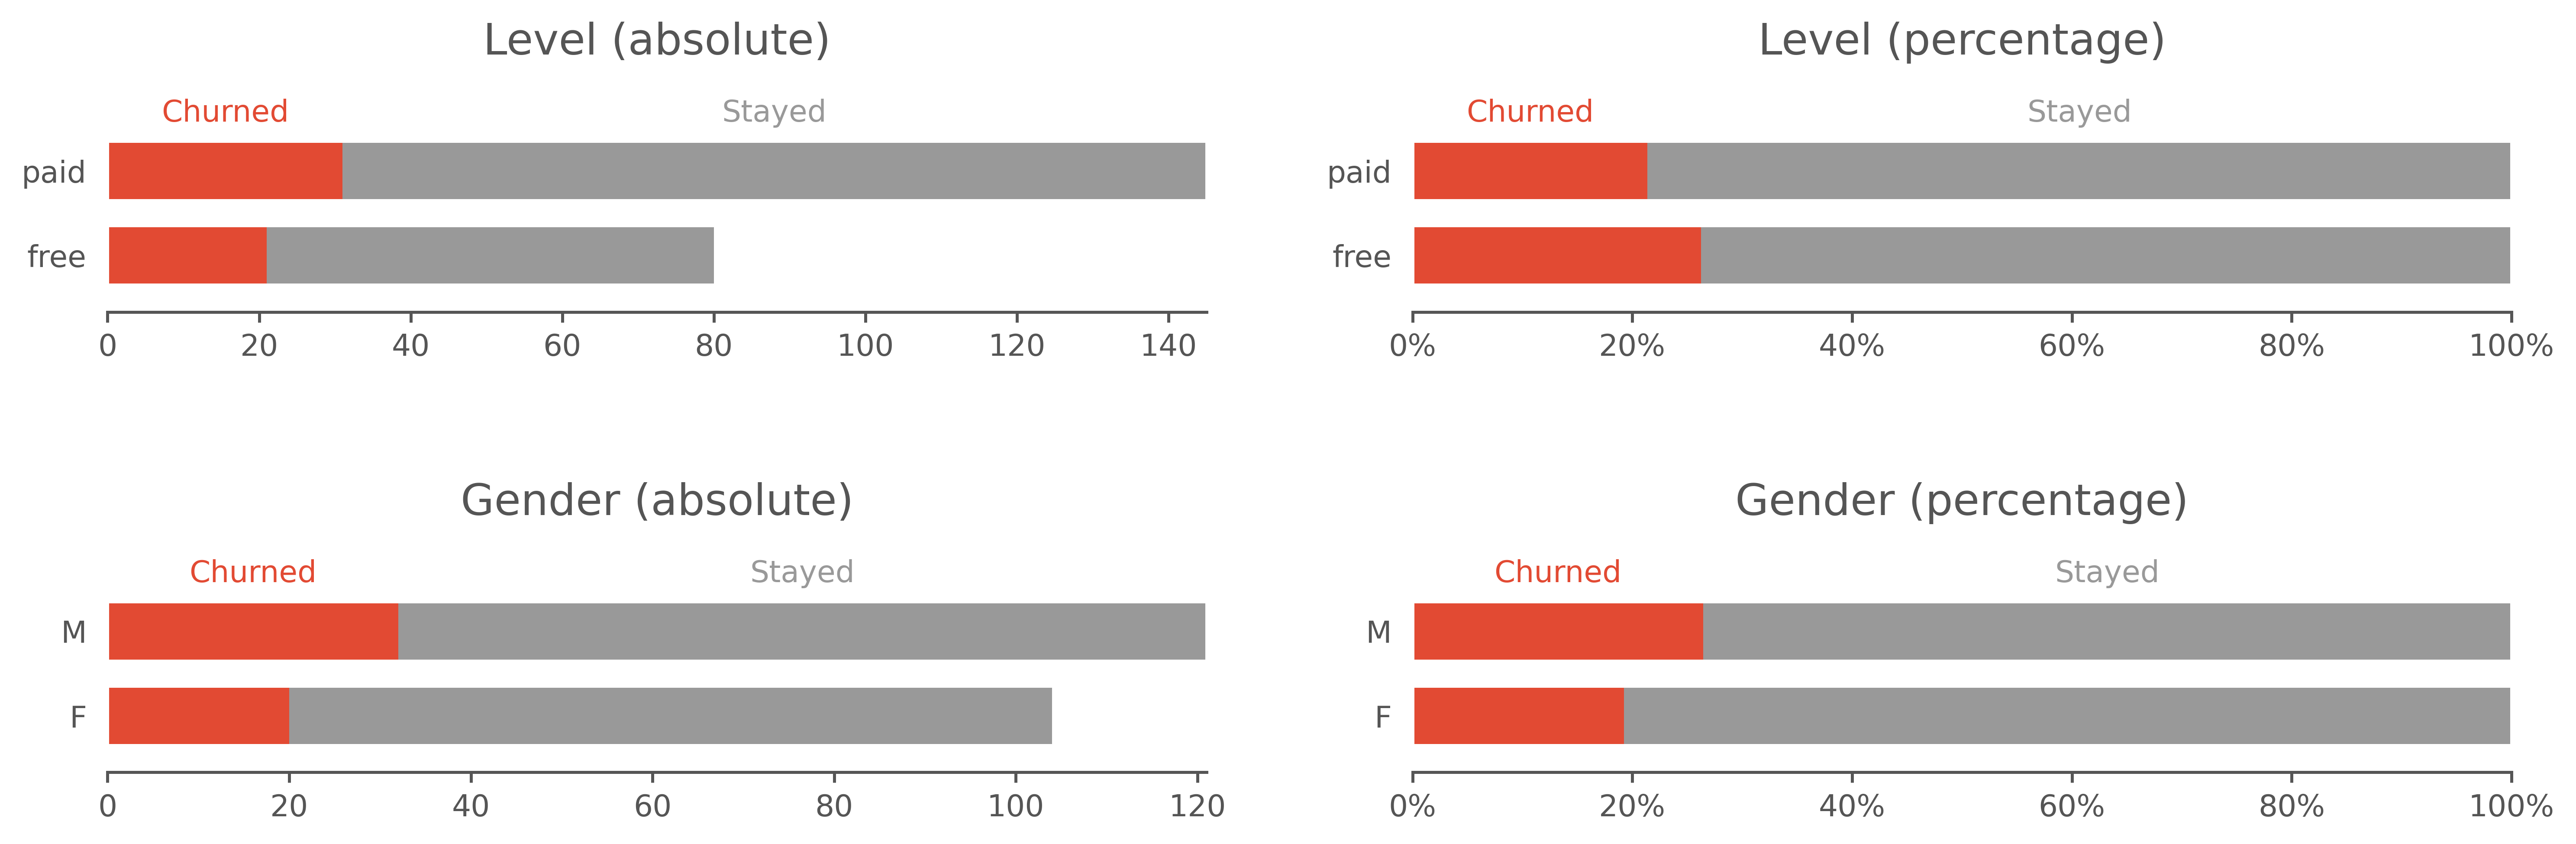

In [57]:
fig = plt.figure(figsize=(12, 4), dpi=500)
grid = gs.GridSpec(nrows=2, ncols=2)

BarhStacked2(c_level,    s_level,    l_level,  'Level (absolute)',    legend           ).subplot(grid, 0, 0)
BarhStacked2(c_level_p,  s_level_p,  l_level,  'Level (percentage)',  legend, perc=True).subplot(grid, 0, 1)
BarhStacked2(c_gender,   s_gender,   l_gender, 'Gender (absolute)',   legend           ).subplot(grid, 1, 0)
BarhStacked2(c_gender_p, s_gender_p, l_gender, 'Gender (percentage)', legend, perc=True).subplot(grid, 1, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [58]:
c_cohort, s_cohort, l_cohort = get_plot_inputs(df_users_features, 'cohort')
c_cohort_p, s_cohort_p = get_percentage(c_cohort, s_cohort)

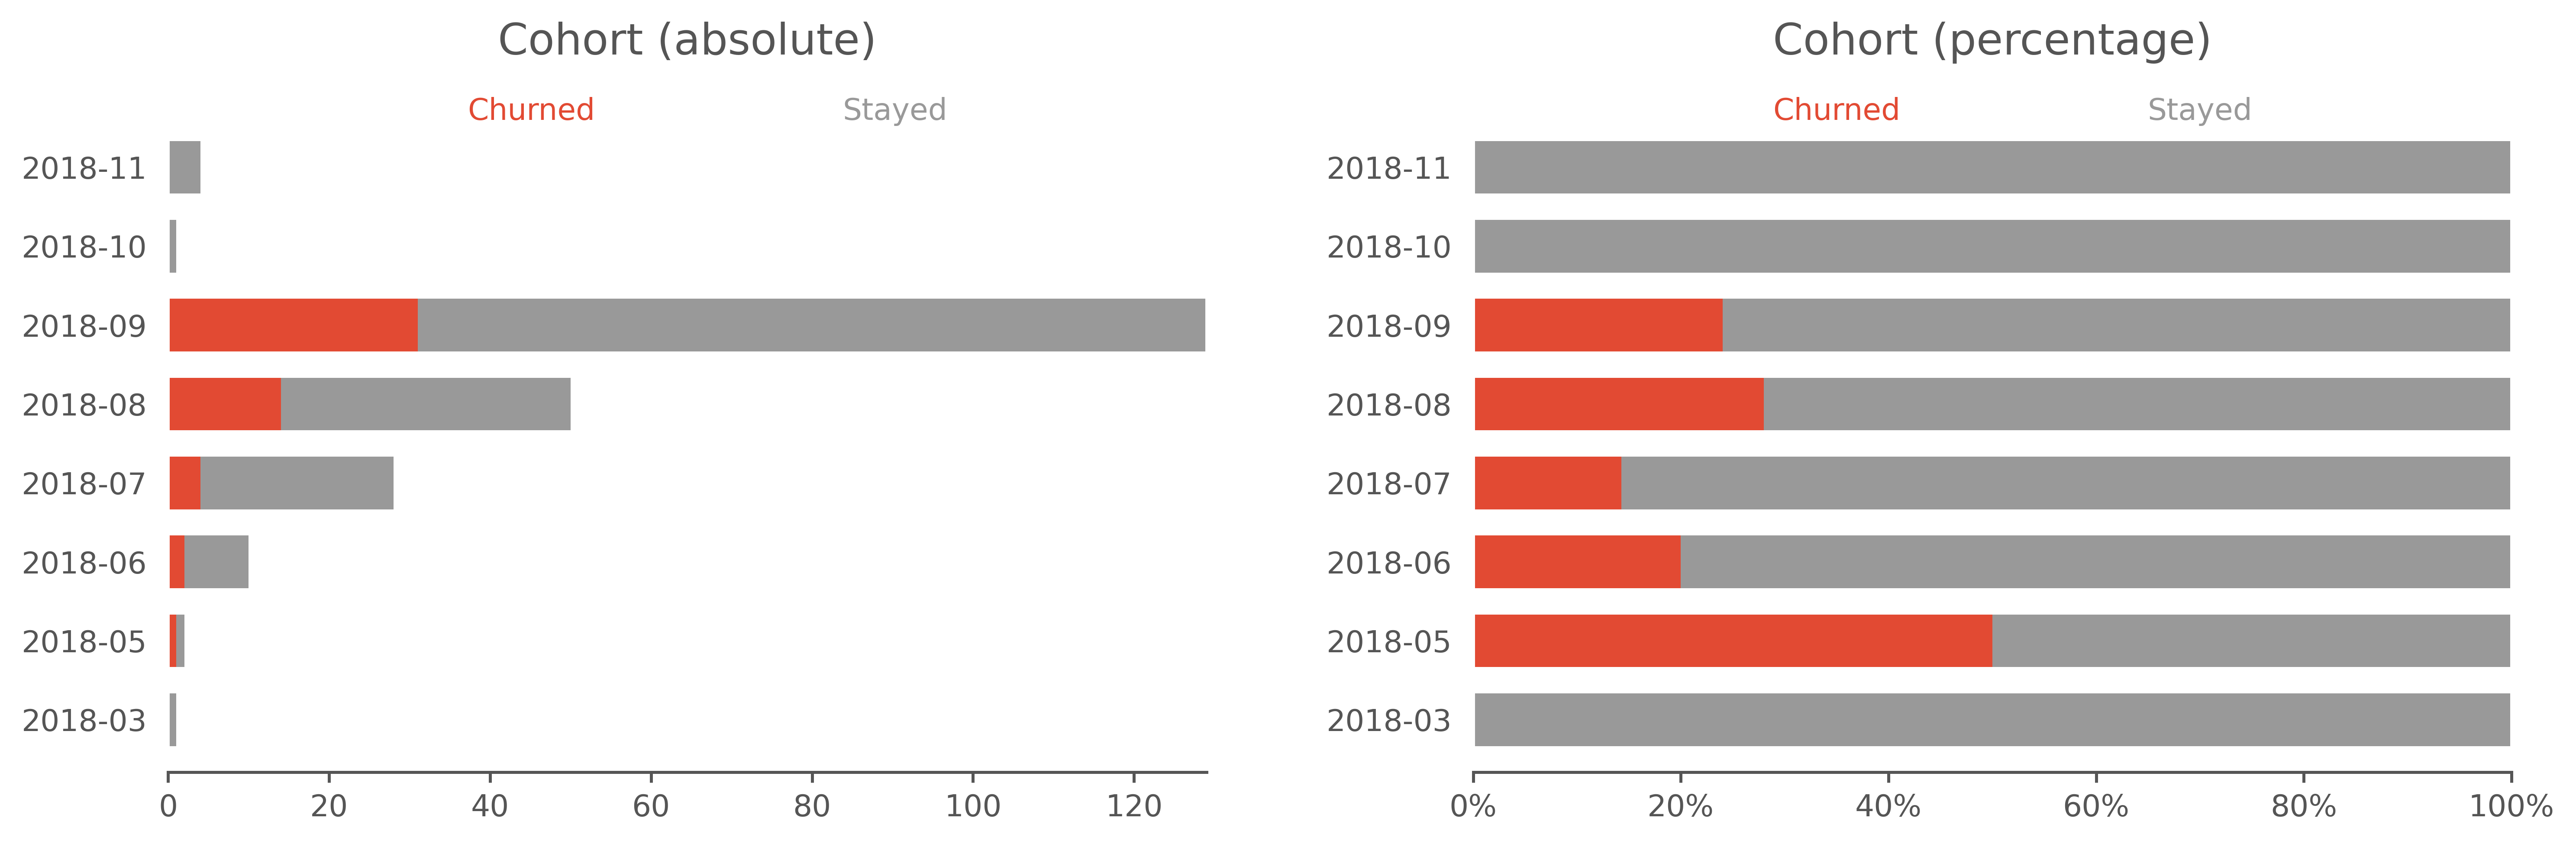

In [59]:
fig = plt.figure(figsize=(12, 4), dpi=500)
grid = gs.GridSpec(nrows=1, ncols=2)

BarhStacked2(c_cohort,   s_cohort,   l_cohort, 'Cohort (absolute)',   legend           ).subplot(grid, 0, 0)
BarhStacked2(c_cohort_p, s_cohort_p, l_cohort, 'Cohort (percentage)', legend, perc=True).subplot(grid, 0, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [60]:
c_browser, s_browser, l_browser = get_plot_inputs(df_users_features, 'browser', order_by='abs')
c_device,  s_device,  l_device  = get_plot_inputs(df_users_features, 'device',  order_by='abs')
c_os,      s_os,      l_os      = get_plot_inputs(df_users_features, 'os',      order_by='abs')

c_browser_p, s_browser_p = get_percentage(c_browser, s_browser)
c_device_p,  s_device_p  = get_percentage(c_device,  s_device)
c_os_p,      s_os_p      = get_percentage(c_os,      s_os)

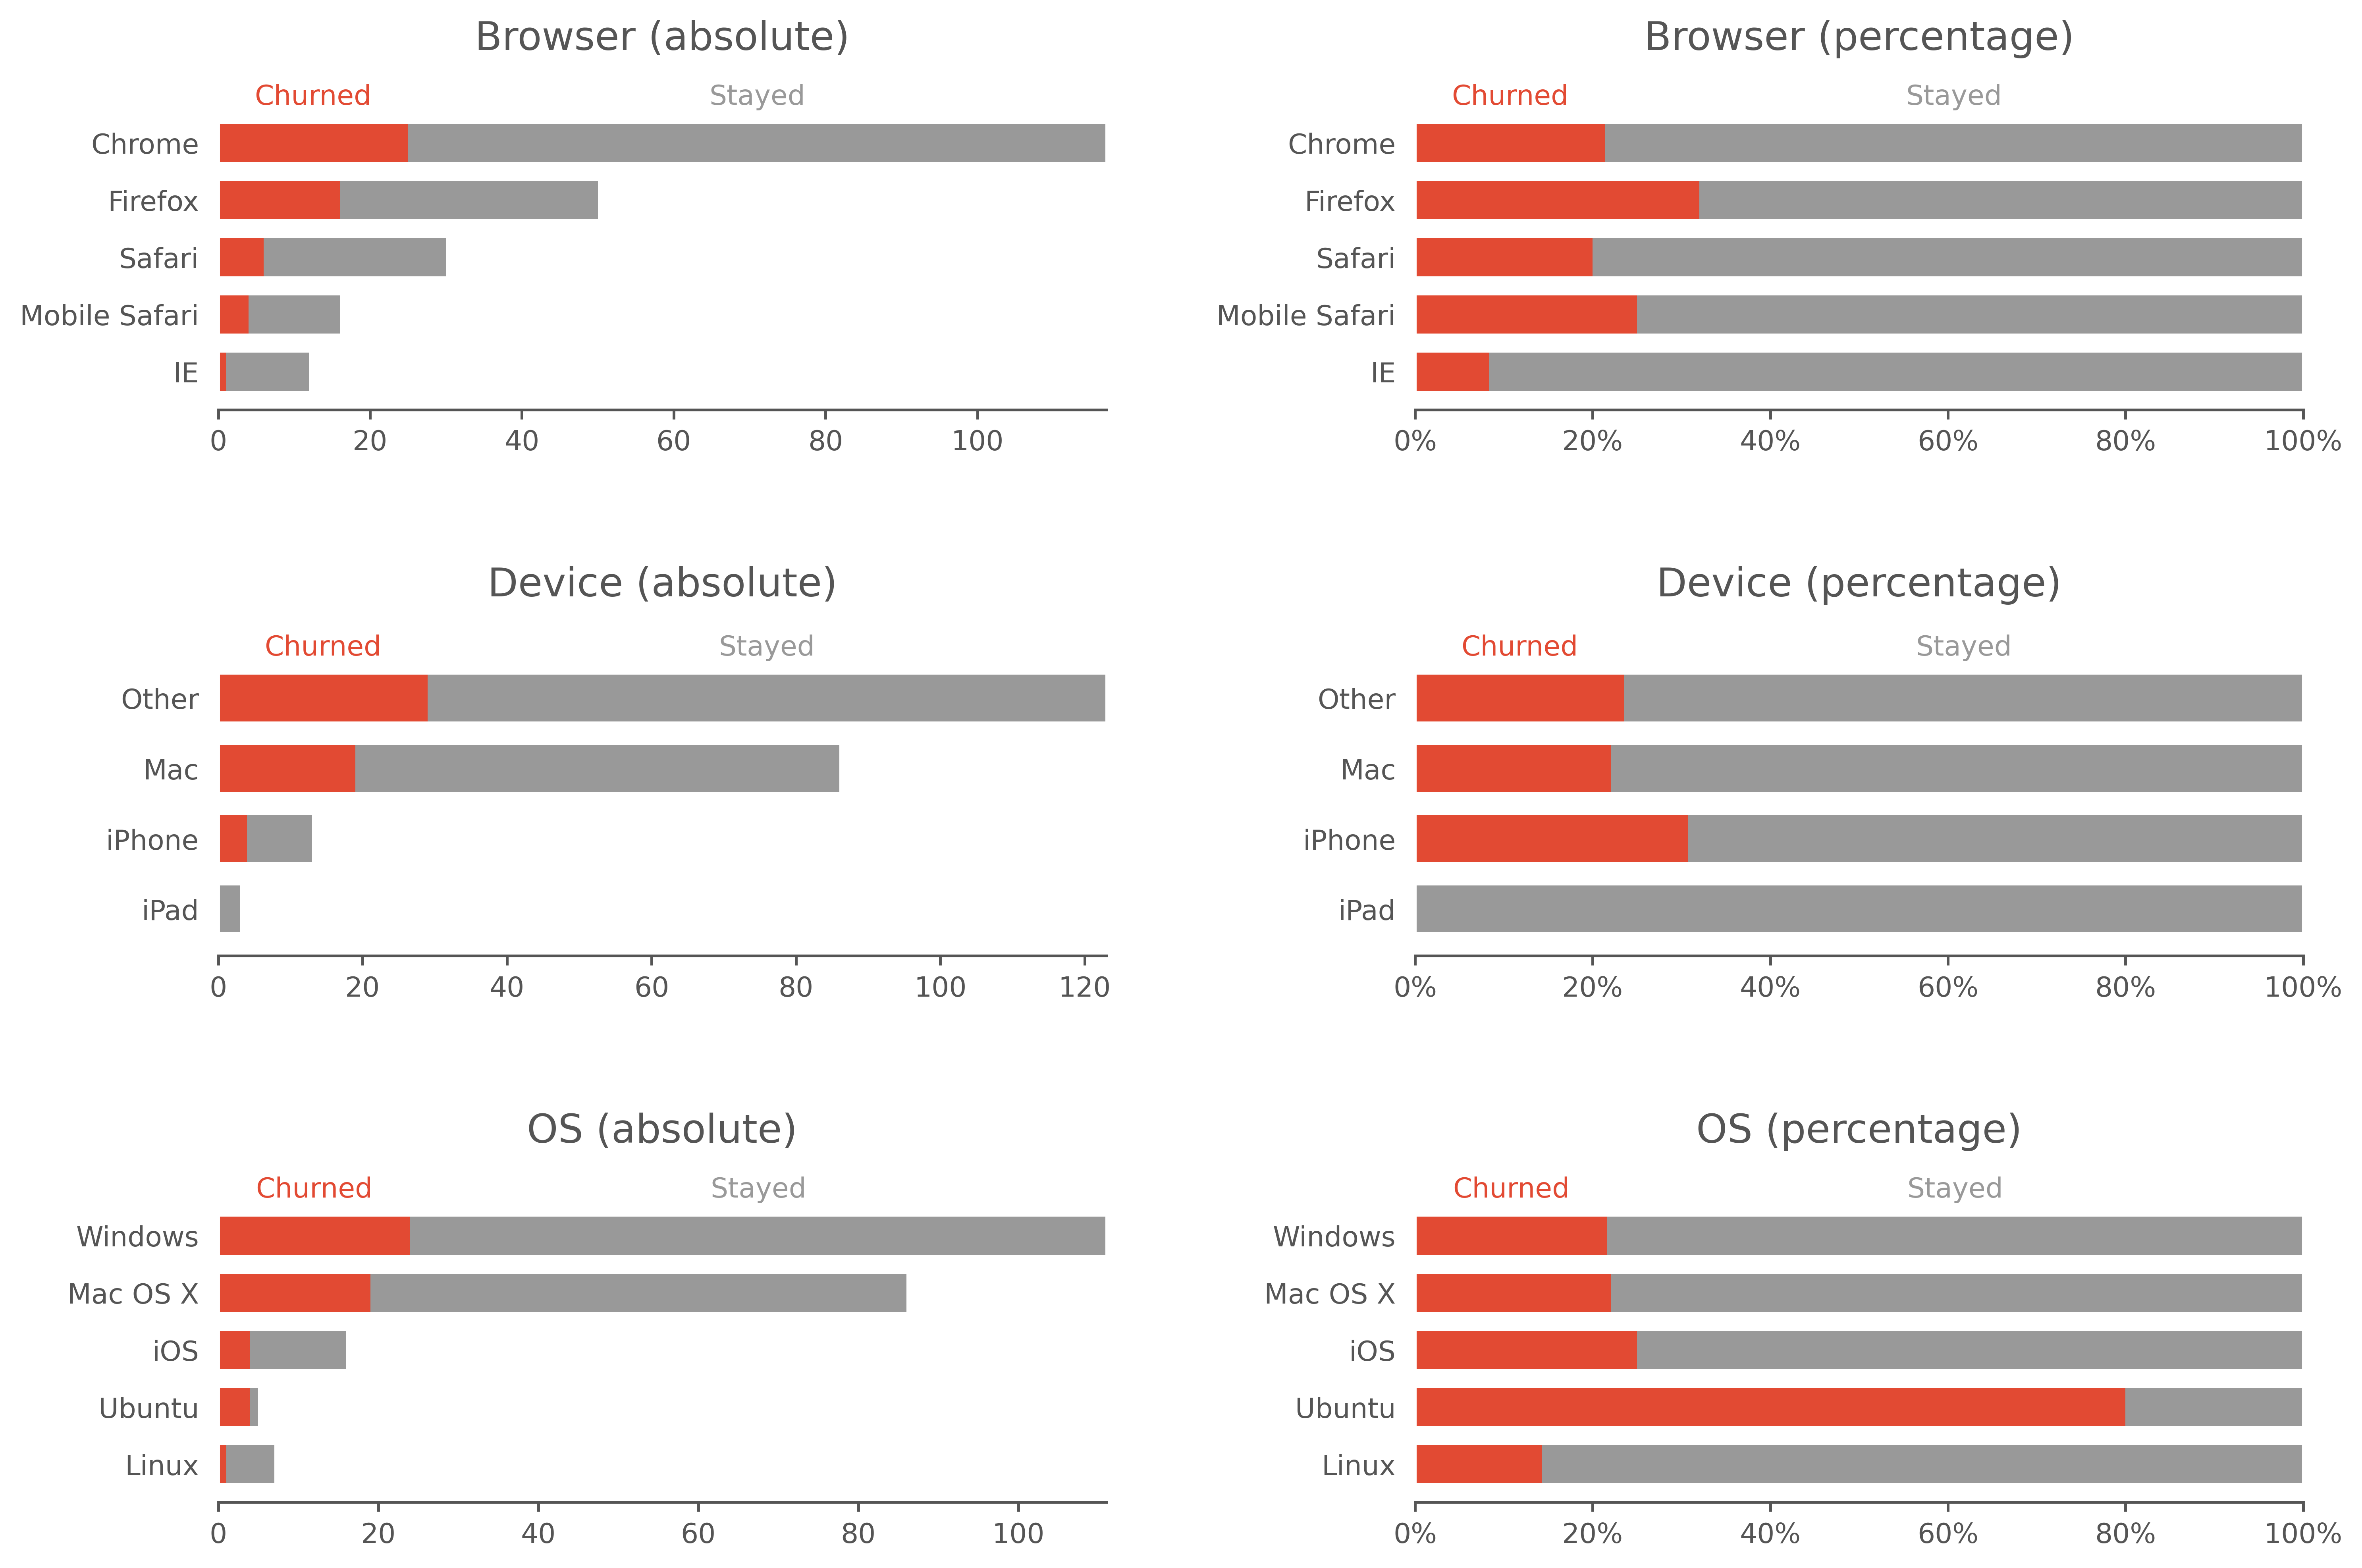

In [61]:
fig = plt.figure(figsize=(12, 8), dpi=500)
grid = gs.GridSpec(nrows=3, ncols=2)

BarhStacked2(c_browser,   s_browser,   l_browser, 'Browser (absolute)',   legend           ).subplot(grid, 0, 0)
BarhStacked2(c_browser_p, s_browser_p, l_browser, 'Browser (percentage)', legend, perc=True).subplot(grid, 0, 1)
BarhStacked2(c_device,    s_device,    l_device,  'Device (absolute)',    legend           ).subplot(grid, 1, 0)
BarhStacked2(c_device_p,  s_device_p,  l_device,  'Device (percentage)',  legend, perc=True).subplot(grid, 1, 1)
BarhStacked2(c_os,        s_os,        l_os,      'OS (absolute)',        legend           ).subplot(grid, 2, 0)
BarhStacked2(c_os_p,      s_os_p,      l_os,      'OS (percentage)',      legend, perc=True).subplot(grid, 2, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [62]:
c_phone,    s_phone,    l_phone    = get_plot_inputs(df_users_features, 'isPhone',    order_by='abs')
c_tablet,   s_tablet,   l_tablet   = get_plot_inputs(df_users_features, 'isTablet',   order_by='abs')
c_computer, s_computer, l_computer = get_plot_inputs(df_users_features, 'isComputer', order_by='abs')

c_phone_p,    s_phone_p    = get_percentage(c_phone,    s_phone)
c_tablet_p,   s_tablet_p   = get_percentage(c_tablet,   s_tablet)
c_computer_p, s_computer_p = get_percentage(c_computer, s_computer)

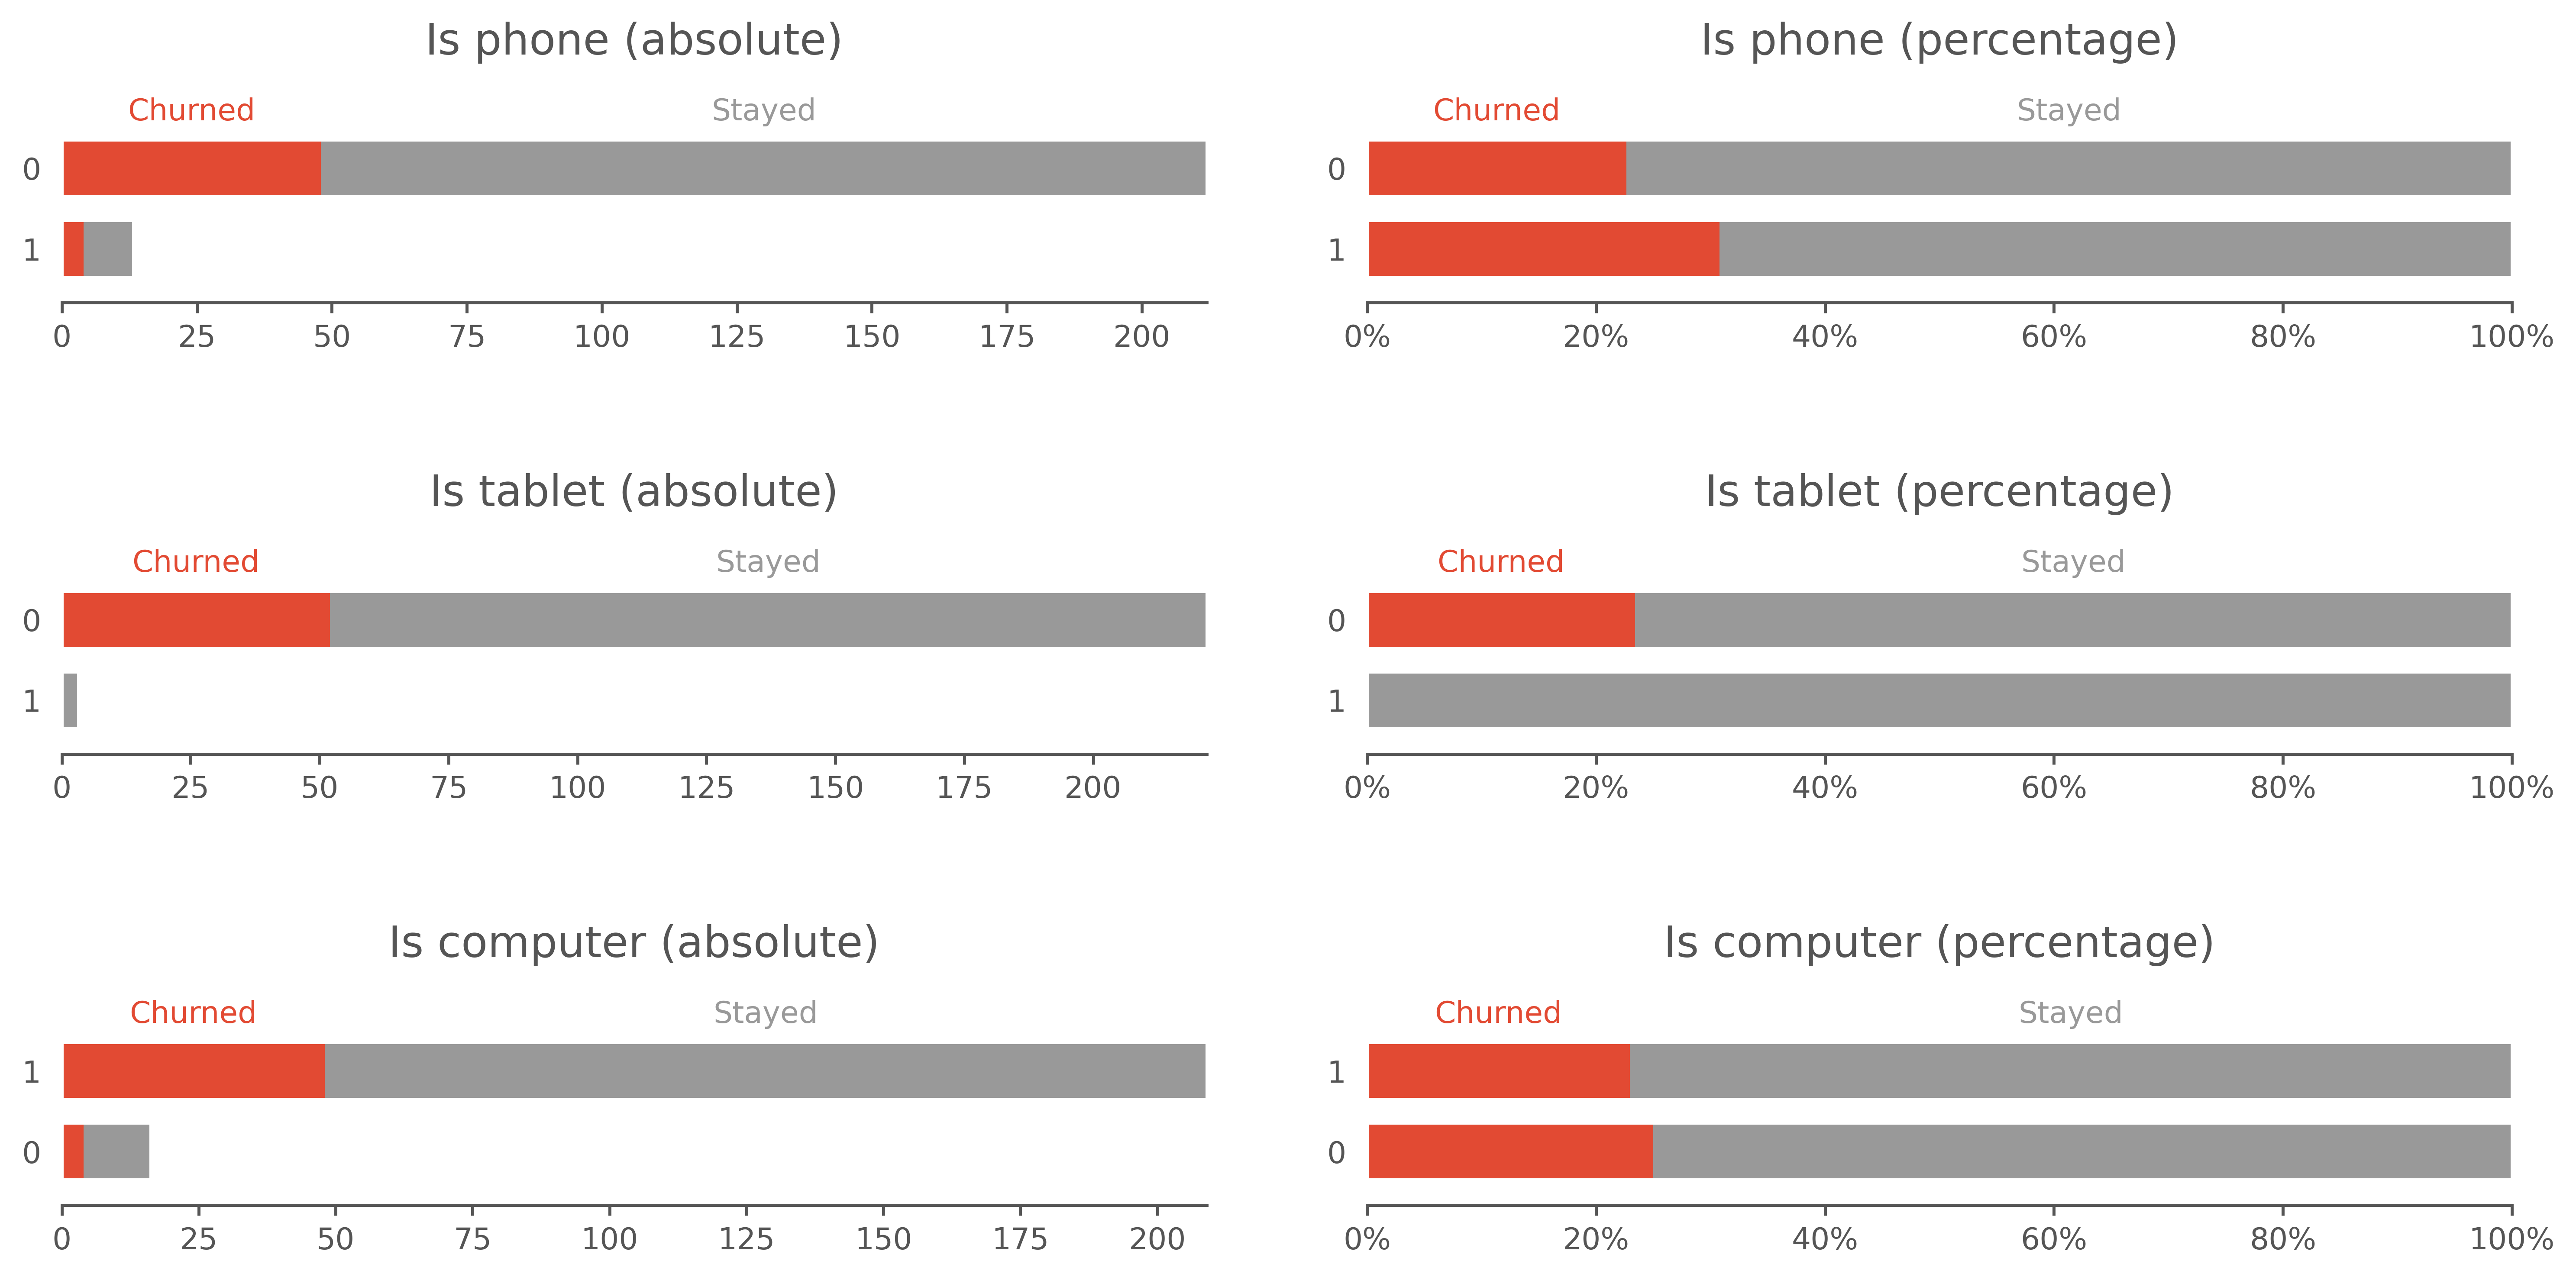

In [63]:
fig = plt.figure(figsize=(12, 6), dpi=500)
grid = gs.GridSpec(nrows=3, ncols=2)

BarhStacked2(c_phone,      s_phone,      l_phone,    'Is phone (absolute)',      legend           ).subplot(grid, 0, 0)
BarhStacked2(c_phone_p,    s_phone_p,    l_phone,    'Is phone (percentage)',    legend, perc=True).subplot(grid, 0, 1)
BarhStacked2(c_tablet,     s_tablet,     l_tablet,   'Is tablet (absolute)',     legend           ).subplot(grid, 1, 0)
BarhStacked2(c_tablet_p,   s_tablet_p,   l_tablet,   'Is tablet (percentage)',   legend, perc=True).subplot(grid, 1, 1)
BarhStacked2(c_computer,   s_computer,   l_computer, 'Is computer (absolute)',   legend           ).subplot(grid, 2, 0)
BarhStacked2(c_computer_p, s_computer_p, l_computer, 'Is computer (percentage)', legend, perc=True).subplot(grid, 2, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

## 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 4.1. Processing features

In [64]:
feature_vector    = 'features'
target_vector     = 'label'
prediction_vector = 'prediction'
seed = 0

In [65]:
df_processed = df_users_features \
    .drop('userId', 'metropolitanArea', 'state') \
    .withColumnRenamed('churned', target_vector)

In [66]:
df_names = df_users_features \
    .drop('userId', 'metropolitanArea', 'state') \
    .withColumnRenamed('churned', target_vector)

In [67]:
indexer_level   = StringIndexer(inputCol='level',   outputCol='levelIndex')
indexer_gender  = StringIndexer(inputCol='gender',  outputCol='genderIndex')
indexer_cohort  = StringIndexer(inputCol='cohort',  outputCol='cohortIndex')
indexer_browser = StringIndexer(inputCol='browser', outputCol='browserIndex')
indexer_device  = StringIndexer(inputCol='device',  outputCol='deviceIndex')
indexer_os      = StringIndexer(inputCol='os',      outputCol='osIndex')

In [68]:
ohe_inputs  = ['levelIndex', 'genderIndex', 'cohortIndex', 'browserIndex', 'deviceIndex', 'osIndex']
ohe_outputs = ['levelOhe',   'genderOhe',   'cohortOhe',   'browserOhe',   'deviceOhe',   'osOhe']

In [69]:
one_hot_encoder = OneHotEncoderEstimator(inputCols=ohe_inputs, outputCols=ohe_outputs)

In [70]:
va_inputs = ['avgSongsWeek',
             'avgSessionsWeek',
             'avgSessionDuration',
             'length',
             'isPhone',
             'isTablet',
             'isComputer',
             'levelOhe',
             'genderOhe',
             'cohortOhe',
             'browserOhe',
             'deviceOhe',
             'osOhe']

In [71]:
vector_assembler = VectorAssembler(inputCols=va_inputs, outputCol=feature_vector)

In [72]:
pipeline_process = Pipeline(stages=[
    indexer_level,
    indexer_gender,
    indexer_cohort,
    indexer_browser,
    indexer_device,
    indexer_os,
    one_hot_encoder,
    vector_assembler
])

In [73]:
%%time
df_processed = pipeline_process.fit(df_processed).transform(df_processed)

CPU times: user 2.23 s, sys: 1.54 s, total: 3.77 s
Wall time: 5min 22s


In [74]:
df_processed.toPandas().head()

,label,avgSongsWeek,avgSessionsWeek,avgSessionDuration,cohort,length,gender,level,browser,os,device,isPhone,isTablet,isComputer,levelIndex,genderIndex,cohortIndex,browserIndex,deviceIndex,osIndex,browserOhe,deviceOhe,osOhe,levelOhe,cohortOhe,genderOhe,features
0,0,51.000000,1.600000,11550.125000,2018-09,255.828061,M,paid,Firefox,Windows,Other,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",(1.0),"(51.0, 1.6, 11550.125, 255.8280605882352, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
1,1,432.571429,4.857143,21945.411765,2018-09,249.180173,M,paid,Safari,Mac OS X,Mac,0,0,1,0.0,0.0,0.0,2.0,1.0,1.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",(1.0),"(432.57142857142856, 4.857142857142857, 21945.41176470588, 249.18017257926041, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)"
2,0,264.125000,2.875000,23050.478261,2018-09,250.524328,M,paid,Firefox,Linux,Other,0,0,1,0.0,0.0,0.0,1.0,0.0,3.0,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",(1.0),"(264.125, 2.875, 23050.478260869564, 250.52432816848082, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
3,0,75.714286,1.142857,15924.250000,2018-09,244.107080,M,free,Chrome,Linux,Other,0,0,1,1.0,0.0,0.0,0.0,0.0,3.0,"(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",(1.0),"(75.71428571428571, 1.1428571428571428, 15924.25, 244.10707988679246, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0)"
4,1,95.200000,1.400000,16286.285714,2018-09,242.654103,M,free,Safari,Mac OS X,Mac,0,0,1,1.0,0.0,0.0,2.0,1.0,1.0,"(0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0)",(0.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",(1.0),"(95.2, 1.4, 16286.285714285714, 242.65410317226892, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0)"


### 4.2. Establishing a baseline

In [75]:
df_train, df_test = df_processed.randomSplit((0.8, 0.2), seed=seed)

### 4.3. Tunning parameters

In [76]:
rf = RandomForestClassifier(featuresCol=feature_vector, labelCol=target_vector, predictionCol=prediction_vector, seed=seed)

In [77]:
estimator = Pipeline(stages=[rf])

In [78]:
grid = ParamGridBuilder().addGrid(rf.numTrees, [20]) \
                         .addGrid(rf.maxDepth, [5]) \
                         .build()

In [79]:
metric = 'f1'

In [80]:
evaluator = MulticlassClassificationEvaluator(predictionCol=prediction_vector, labelCol=target_vector, metricName=metric)

In [81]:
cv = CrossValidator(estimator=estimator, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3, seed=seed)

In [82]:
%%time
model = cv.fit(df_train)

CPU times: user 4.17 s, sys: 2.69 s, total: 6.86 s
Wall time: 13min 1s


In [83]:
score = evaluator.evaluate(model.transform(df_test))

best_model = model.bestModel
max_depth = best_model.stages[0].getOrDefault('maxDepth')
num_trees = best_model.stages[0].getOrDefault('numTrees')

print('The {} score on the test set is: {:.4%}'.format(metric.upper(), score))
print('Best parameters: maxDepth: {}, numTrees: {}'.format(max_depth, num_trees))

The F1 score on the test set is: 83.1727%
Best parameters: maxDepth: 5, numTrees: 20


In [84]:
def print_feature_importances(best_model, df, decimal=4):
    """Print a table with the names of the features and their feature importances in a descending order.
    
    Parameters:
        best_model (pyspark.ml.pipeline.PipelineModel): The best model from the cross validation.
        df (pyspark.sql.dataframe.DataFrame): The post processed dataframe that contains the 'features' column from the vector assembler output.
        decimal (int): The number of decimal places of the score to be shown in the table.
    
    Returns:
        None.
    """
    
    features = [attr['name'] for attr in (chain(*df.schema['features'].metadata['ml_attr']['attrs'].values()))]
    
    scores = list(best_model.stages[0].featureImportances)
    
    # Sort features according to the highest score
    zipped_lists = zip(scores, features)
    sorted_zipped_lists = sorted(zipped_lists, reverse=True)
    unzipped_list = list(zip(*sorted_zipped_lists))
    scores, features = list(unzipped_list[0]), list(unzipped_list[1])
    
    # Define the name of the columns for the table header
    header_1_name = 'feature'
    header_2_name = 'importance'
    
    # Garantee the width of the columns are at least the same width of the header names
    width = len(max(features, key=len))
    if width < len(header_1_name):
        border_header_1 = len(header_1_name)
    else:
        border_header_1 = width
    
    if len('0.') + decimal < len(header_2_name):
        border_header_2 = len(header_2_name)
    else:
        border_header_2 = len('0.') + decimal
    
    # Number of characters to left align the strings
    align = border_header_2
    
    # Calculate number of spaces needed after the header name
    header_1_spaces = width - len(header_1_name)
    header_2_spaces = (len('0.') + decimal) - len(header_2_name)
    
    # Build border and header strings according to the width of the header names, features and decimal places
    border = '+' + '-'*border_header_1 + '+' + '-'*border_header_2 + '+'
    header = '|' + header_1_name + ' '*header_1_spaces + '|' + header_2_name + ' '*header_2_spaces + '|'
    
    # Print results in a fancy table
    print(border)
    print(header)
    print(border)
    for i in range(len(features)):
        print('|{:{width}}|{:<{align}.{decimal}f}|'.format(features[i], scores[i], width=width, align=align, decimal=decimal))
    print(border)

In [86]:
print_feature_importances(best_model, df_processed)

+------------------------+----------+
|feature                 |importance|
+------------------------+----------+
|length                  |0.2065    |
|avgSessionsWeek         |0.1813    |
|avgSessionDuration      |0.1505    |
|avgSongsWeek            |0.1490    |
|genderOhe_M             |0.0531    |
|browserOhe_Firefox      |0.0396    |
|levelOhe_paid           |0.0362    |
|deviceOhe_Mac           |0.0255    |
|cohortOhe_2018-08       |0.0234    |
|browserOhe_Chrome       |0.0225    |
|cohortOhe_2018-07       |0.0169    |
|osOhe_Windows           |0.0140    |
|osOhe_iOS               |0.0139    |
|cohortOhe_2018-09       |0.0136    |
|deviceOhe_Other         |0.0108    |
|browserOhe_Safari       |0.0107    |
|browserOhe_Mobile Safari|0.0082    |
|cohortOhe_2018-06       |0.0080    |
|osOhe_Linux             |0.0057    |
|osOhe_Mac OS X          |0.0037    |
|cohortOhe_2018-11       |0.0034    |
|isComputer              |0.0024    |
|deviceOhe_iPhone        |0.0009    |
|isPhone    

### 4.4. Saving model

In [5]:
path = '/Users/gabriel.tempass/Repositories/sparkify-churn-prediction/model'

In [368]:
try:
    best_model.save(path)
except:
    best_model.write().overwrite().save(path)

In [6]:
# To load model:
best_model = PipelineModel.load(path)